# AWS Glue Studio Notebook
##### You are now running a AWS Glue Studio notebook; To start using your notebook you need to start an AWS Glue Interactive Session.


#### Optional: Run this cell to see available notebook commands ("magics").


In [ ]:
%help

####  Run this cell to set up and start your interactive session.


In [1]:
%idle_timeout 2880
%glue_version 4.0
%worker_type G.1X
%number_of_workers 5

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.5 
Current idle_timeout is None minutes.
idle_timeout has been set to 2880 minutes.
Setting Glue version to: 4.0
Previous worker type: None
Setting new worker type to: G.1X
Previous number of workers: None
Setting new number of workers to: 5
Trying to create a Glue session for the kernel.
Session Type: glueetl
Worker Type: G.1X
Number of Workers: 5
Idle Timeout: 2880
Session ID: cc6c8a84-5b08-4314-a1e7-d2bf8b1baea5
Applying the following default arguments:
--glue_kernel_version 1.0.5
--enable-glue-datacatalog true
Waiting for session cc6c8a84-5b08-4314-a1e7-d2bf8b1baea5 to get into ready status...
Session cc6c8a84-5b08-4314-a1e7-d2bf8b1baea5 ha

#### Reading file


In [81]:
input_path = "s3://pyspark-analysis/listing.csv.gz"

# Read the gzipped CSV file from S3 into a DynamicFrame
dyf = glueContext.create_dynamic_frame.from_options(
    connection_type="s3",
    connection_options={"paths": [input_path]},
    format="csv",
    format_options={
        "withHeader": True,
        "separator": ",",
        "compression": "gzip"
    }
)

# Convert the DynamicFrame to a DataFrame if needed
df = dyf.toDF()

# Show the first few rows of the DataFrame
df.show(1)

+------+--------------------+--------------+------------+---------------+--------------------+--------------------+---------------------+--------------------+-------+--------------------+-----------------+----------+-----------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+---------+----------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------

#### Example: Convert the DynamicFrame to a Spark DataFrame and display a sample of the data


In [ ]:
df = dyf.toDF()
df.show(5)

+-----+--------------------+--------------+------------+---------------+--------------------+--------------------+---------------------+--------------------+-------+--------------------+--------------+----------+-----------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------+---------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------

#### Example: Visualize data with matplotlib


<BarContainer object of 5 artists>



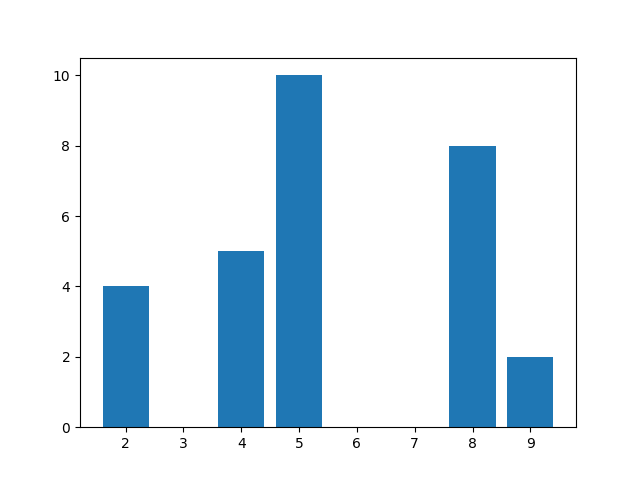

In [ ]:
import matplotlib.pyplot as plt

# Set X-axis and Y-axis values
x = [5, 2, 8, 4, 9]
y = [10, 4, 8, 5, 2]
  
# Create a bar chart 
plt.bar(x, y)
  
# Show the plot
%matplot plt

#### Example: Write the data in the DynamicFrame to a location in Amazon S3 and a table for it in the AWS Glue Data Catalog


In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_acceptance_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_thumbnail_url: string (nullable = true)
 |-- host_picture_url: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_listings_cou

In [ ]:
from pyspark.sql import functions as F

def to_numerical(df):
    # Remove the dollar signs and commas, then convert to numeric (double)
    df = df.withColumn('price', F.regexp_replace('price', '\\$', ''))
    df = df.withColumn('price', F.regexp_replace('price', ',', ''))
    df = df.withColumn('price', F.col('price').cast('double'))
    return df
df = to_numerical(df)

In [ ]:
def taking_numerical_values(df, columns):
    for column in columns:
        # Use regexp_extract to extract the numerical part from the string
        df = df.withColumn(column, F.regexp_extract(F.col(column), r'(\d+(\.\d+)?)', 0).cast('double'))
    return df
columns = ['bathrooms_text']
df = taking_numerical_values(df, columns)

In [ ]:
df.select('price','bathrooms_text').show(5)

+-----+--------------+
|price|bathrooms_text|
+-----+--------------+
| null|           3.0|
| null|           1.5|
|145.0|           1.0|
| 75.0|           1.0|
| null|           1.5|
+-----+--------------+
only showing top 5 rows


In [ ]:
def removing_the_percentsign(df, columns):
    for column in columns:
        # Remove the percentage sign and convert to float
        df = df.withColumn(column, F.regexp_replace(F.col(column), '%', '').cast('double'))
    return df

columns = ['host_response_rate', 'host_acceptance_rate']
df = removing_the_percentsign(df, columns)

In [ ]:
def trim_all_columns(df):
    # Applying `trim` to all string columns in the DataFrame
    for column in df.columns:
        df = df.withColumn(column, F.trim(F.col(column)))
    return df

df = trim_all_columns(df)

In [ ]:
df.select('host_location').distinct().show(truncate=False)

+---------------------------+
|host_location              |
+---------------------------+
|London, United Kingdom     |
|England, United Kingdom    |
|Nova Scotia, Canada        |
|Scarborough, United Kingdom|
|Richmond Hill, Canada      |
|Lyon, France               |
|Banff, Canada              |
|Buenos Aires, Argentina    |
|Essex, Canada              |
|Seoul, South Korea         |
|Richmond, Canada           |
|West Becher, Canada        |
|Cambridge, Canada          |
|Marbella, Spain            |
|New Minas, Canada          |
|Sudbury, Canada            |
|Tokyo, Japan               |
|King City, Canada          |
|Timmins, Canada            |
|Tamarindo, Costa Rica      |
+---------------------------+
only showing top 20 rows


In [ ]:
number_of_null = df.filter(F.col('price').isNull()).count()
total_data = df.count()
percentage_null = (number_of_null / total_data) * 100

print(f'Percentage of null values in price: {percentage_null:.2f}%')

Percentage of null values in price: 18.97%


In [ ]:
average_price_df = df.groupBy('neighbourhood_cleansed', 'property_type', 'accommodates') \
                     .agg(F.avg('price').alias('average_price'))


df = df.join(average_price_df, 
             on=['neighbourhood_cleansed', 'property_type', 'accommodates'], 
             how='left')

# Fill null values in the price column with the calculated average price
df = df.withColumn('price', F.coalesce(F.col('price'), F.col('average_price')))

df = df.drop('average_price')

In [ ]:
number_of_null = df.filter(F.col('price').isNull()).count()
number_of_null

38


In [ ]:
# These 38 column is missing property type and accommodates so rather that using avergae to fill droping the rows
df = df.dropna(subset=['price'])

In [ ]:
number_of_null = df.filter(F.col('neighbourhood_group_cleansed').isNull()).count()
(number_of_null)

248485


In [ ]:
total_data = df.count()

# Calculate the percentage of null values in all columns
null_percentage_df = df.select([ 
    (F.count(F.when(F.col(column).isNull(), column)) / total_data * 100).alias(column) 
    for column in df.columns
])

# Show the percentage of null values for each column
null_percentage_df.show(truncate=False)

+----------------------+-------------+------------+---------+---+-----------+---------+------------+------+----+---------------------+-----------+-------+--------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+----------------------+--------+---------+------------------+--------+--------------------+---------+-----+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------+---------------+---------------+---------------+----------------+---------------------+-----------------+---------------------+----------------------+------------------+------------------+--------------------+----------------------+-------------------------+---------------------+--------------

In [ ]:
null_percentage_df.select('host_acceptance_rate','host_response_rate').show()

+--------------------+------------------+
|host_acceptance_rate|host_response_rate|
+--------------------+------------------+
|                 0.0|               0.0|
+--------------------+------------------+


In [ ]:
null_percentage_df.show(3)

+----------------------+-------------+------------+---------+---+-----------+---------+------------+------+----+---------------------+-----------+-------+--------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+----------------------+--------+---------+------------------+--------+--------------------+---------+-----+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------+---------------+---------------+---------------+----------------+---------------------+-----------------+---------------------+----------------------+------------------+------------------+--------------------+----------------------+-------------------------+---------------------+--------------

In [ ]:
number_of_null_or_empty = df.filter(F.col('bathrooms').isNull() | (F.col('bathrooms') == "")).count()
print(f'Number of null or empty values in bathrooms: {number_of_null_or_empty}')

In [ ]:
null_percentage_df = df.select([
    (F.count(F.when(F.col(column).isNull() | (F.col(column) == ""), column)) / total_data * 100).alias(column)
    for column in df.columns
])

# Show the percentage of null values for each column
null_percentage_df.show(truncate=False)

In [ ]:
null_percentage_results = null_percentage_df.first().asDict()

# Filter columns where the percentage is more than 10%
columns_above_10_percent = {column: percentage for column, percentage in null_percentage_results.items() if percentage > 10}

# Display the columns with more than 10% null and empty values
print("Columns with more than 10% null or empty values:")
for column, percentage in columns_above_10_percent.items():
    print(f"{column}: {percentage:.2f}%")

In [ ]:
# Columns to drop
## description: 18.08%
#### host_location: 25.45% (Droping the column, doesn't significently impact the price by where host is from)
#### host_about: 53.04%
#### neighbourhood: 46.34% (Have this info in neighbourhood cleaned)
#### neighbourhood_group_cleansed: 100.00% (group location is toronto)
#### bathrooms: 49.03% (Drop) have this info in Bathroom_text
#### calendar_updated: 100.00% (Just indicate when data was uploaded irrelivent) 
#### host_neighbourhood: 59.33% (Where the host are from)


# Columns to fill null values with some values
'''host_response_time: 30.42%
host_response_rate: 30.42%
host_acceptance_rate: 26.06%

bedrooms: 26.97%
beds: 17.47%'''
## neighborhood_overview: 46.34% (we can fill this data with neighborhood overview of other listing present in that neighbourhood)


'''first_review: 25.26%
last_review: 25.26%
review_scores_rating: 25.24%
review_scores_accuracy: 25.35%
review_scores_cleanliness: 25.34%
review_scores_checkin: 25.35%
review_scores_communication: 25.35%
review_scores_location: 25.35%
review_scores_value: 25.35%
license: 52.63%
reviews_per_month: 25.26%'''
# these field we can check on reviews table

In [86]:
# Converting the numerical columns to numerical values
columns_to_convert = [
    'id',
    'scrape_id',
    'host_id',
    'latitude',
    'longitude',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'maximum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'reviews_per_month'
]

for column in columns_to_convert:
    df = df.withColumn(column, F.col(column).cast('float'))

In [88]:
df_room = df.select('room_type','property_type','accommodates', 'beds', 'bedrooms')
df_room.printSchema()

root
 |-- room_type: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- accommodates: float (nullable = true)
 |-- beds: float (nullable = true)
 |-- bedrooms: float (nullable = true)


In [90]:
# Changing the empty string to None (null value)
for column in df.columns:
    df = df.withColumn(column, F.when(F.col(column) == '', None).otherwise(F.col(column)))

In [8]:
# Filling beds and bedrooms with average of accommodates and room_type

In [93]:
average_values = df.groupBy('room_type', 'accommodates') \
    .agg(
        F.avg('beds').alias('avg_beds'),
        F.avg('bedrooms').alias('avg_bedrooms')
    )

df = df.join(average_values, on=['room_type', 'accommodates'], how='left')


df = df.withColumn('beds', F.coalesce(F.col('beds'), F.col('avg_beds'))) \
    .withColumn('bedrooms', F.coalesce(F.col('bedrooms'), F.col('avg_bedrooms')))

df = df.drop('avg_beds', 'avg_bedrooms')


In [9]:
# response_columns = ['host_response_time', 'host_response_rate', 'host_acceptance_rate'] filling response column

In [96]:
response_columns = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']

average_response_values = df.agg(
    *[F.avg(column).alias(f'avg_{column}') for column in response_columns]
)

# Collecting the average values into a dictionary
avg_values = average_response_values.first().asDict()

# Filling missing values in the response columns with the calculated averages
for column in response_columns:
    df = df.withColumn(column, F.coalesce(F.col(column), F.lit(avg_values[f'avg_{column}'])))

In [99]:
# Droping unwanted columns
unwanted_column = []
df = df.drop('description','host_location', 'host_about', 'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'host_neighbourhood')

In [101]:
df.select('license').show(4)

+---------------+
|        license|
+---------------+
|STR-2307-JDVPHZ|
|STR-2307-JDVPHZ|
|STR-2309-FWPRVR|
|STR-2009-GPCHBG|
+---------------+
only showing top 4 rows


In [103]:
# Filling null license with Zero (means doesn't have license)
df = df.fillna({'license': '0'})


In [105]:
# Filling host_response_time with 2 hours which is above the average response time
df = df.fillna({'host_response_time':5})

In [107]:
# Filling the neighborhood_overview column with the overview from other listings that share the same neighbourhood_cleansed

agg_df = df.groupBy("neighbourhood_cleansed") \
            .agg(F.first("neighborhood_overview").alias("overview"))  # Get the first non-null overview for each neighborhood

# Join the aggregated DataFrame back to the original DataFrame
df = df.join(agg_df, on="neighbourhood_cleansed", how="left")

# Filling the null values in neighborhood_overview with the overview from the aggregated DataFrame
df = df.withColumn(
    "neighborhood_overview",
    F.coalesce(df["neighborhood_overview"], df["overview"])
)

df = df.drop("overview")

In [109]:
# For has_availability checking the availability_30, availability_60, availability_90, availability_365

df.select('availability_30', 'availability_60', 'availability_90', 'availability_365', 'has_availability').show(10)

+---------------+---------------+---------------+----------------+----------------+
|availability_30|availability_60|availability_90|availability_365|has_availability|
+---------------+---------------+---------------+----------------+----------------+
|           30.0|           60.0|           89.0|            89.0|               t|
|           14.0|           44.0|           73.0|            73.0|               t|
|           30.0|           60.0|           90.0|            90.0|               t|
|           30.0|           60.0|           89.0|            89.0|               t|
|           30.0|           60.0|           90.0|            90.0|               t|
|           19.0|           49.0|           79.0|            79.0|               t|
|            0.0|           18.0|           48.0|            48.0|               t|
|            0.0|            0.0|           16.0|            16.0|               t|
|           30.0|           60.0|           90.0|            90.0|          

In [111]:
df = df.withColumn(
    "has_availability",
    F.when(
        (F.col("availability_30") == 0) & 
        (F.col("availability_60") == 0) & 
        (F.col("availability_90") == 0) & 
        (F.col("availability_365") == 0), "f"
    ).otherwise("t")
)

In [112]:
df = df.fillna({'host_is_superhost':'f'})

In [118]:
df = df.fillna({'neighborhood_overview': 'UNKNOWN'})

In [ ]:
# Uploading the review file to check if missing reviews are available 

input_path = "s3://pyspark-analysis/reviews.csv.gz"

# Reading the gzipped CSV file from S3 into a DynamicFrame
dyf = glueContext.create_dynamic_frame.from_options(
    connection_type="s3",
    connection_options={"paths": [input_path]},
    format="csv",
    format_options={
        "withHeader": True,
        "separator": ",",
        "compression": "gzip"
    }
)

# Convert the DynamicFrame to a DataFrame if needed
df_review = dyf.toDF()

# Show the first few rows of the DataFrame
df_review.show(10)


In [113]:
Review_Count = df_review.groupBy("listing_id", "Month").agg(F.count("comments").alias("comment_count"))

In [114]:
Review_Count.filter(F.col('listing_id') == '4567809').show()

+----------+-----+-------------+
|listing_id|Month|comment_count|
+----------+-----+-------------+
+----------+-----+-------------+


In [115]:
null_review = df.select('review_scores_rating','review_scores_accuracy','host_since','id','host_id')
null_review.filter(F.col('review_scores_rating').isNull()).show(10)

+--------------------+----------------------+----------+-------------+------------+
|review_scores_rating|review_scores_accuracy|host_since|           id|     host_id|
+--------------------+----------------------+----------+-------------+------------+
|                null|                  null|2023-09-14|  9.893495E17| 5.3718496E8|
|                null|                  null|2024-04-04|1.12768744E18| 5.7062707E8|
|                null|                  null|2022-09-19|  9.783662E17|4.80211488E8|
|                null|                  null|2015-04-14|    6013874.0| 3.1217284E7|
|                null|                  null|2015-10-11|  6.295673E17|  4.625804E7|
|                null|                  null|2023-01-30| 8.9800193E17|4.98753984E8|
|                null|                  null|2023-02-25| 9.4213173E17|5.02787392E8|
|                null|                  null|2016-06-19|1.02115136E18|   7.86746E7|
|                null|                  null|2022-02-04|1.06445913E18|4.4358

In [127]:
final_df = final_df.drop('first_review','last_review')

In [120]:
# Cant find any of the reviews related data
## First fillup method, checking if that listing belongs to host who owns other listing if some filling with same ratings
## Considering they never received a review and filling with zero.

df.printSchema()
# Filling remaining nulls with zero for listings with no reviews
final_df = df.fillna({
    "review_scores_rating": 0.0,
    "review_scores_accuracy": 0.0,
    "review_scores_cleanliness": 0.0,
    "review_scores_checkin": 0.0,
    "review_scores_communication": 0.0,
    "review_scores_location": 0.0,
    "review_scores_value": 0.0,
    "reviews_per_month": 0.0
})






root
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- neighborhood_overview: string (nullable = false)
 |-- picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_response_time: string (nullable = false)
 |-- host_response_rate: string (nullable = false)
 |-- host_acceptance_rate: string (nullable = false)
 |-- host_is_superhost: string (nullable = false)
 |-- host_thumbnail_url: string (nullable = true)
 |-- host_picture_url: string (nullable = true)
 |-- host_lis

In [125]:
null_percentage_df = final_df.select([
    (F.count(F.when(F.col(column).isNull(), column)) / total_data * 100).alias(column)
    for column in df.columns
])

null_percentage_results = null_percentage_df.first().asDict()


columns_above_10_percent = {column: percentage for column, percentage in null_percentage_results.items() if percentage > 1}

# Display the columns with more than 1% null and empty values
print("Columns with more null or empty values:")
for column, percentage in columns_above_10_percent.items():
    print(f"{column}: {percentage:.2f}%")



Columns with more null or empty values:
first_review: 25.26%
last_review: 25.26%


In [128]:
final_df = final_df.drop('first_review','last_review')

In [131]:
final_df = final_df.repartition(1)
s3_path = "s3://pyspark-analysis/final_data.csv"

# Write the DataFrame to S3 in Parquet format
final_df.write.mode('overwrite').option("header", "true").csv(s3_path)